## Before re-running the notebook:

1. Data ETL part will take about 20 - 30 minutes to run. The result will be saved to a csv file called dataset.csv after the process, in the same directory of the python file. This file has already been generated, and can be used directly in later parts to avoid re-running the ETL.

2. The 2 visualization of UAA scores will take approximately 10 minutes each to generate. The graph has already been produced. 

3. The grid-search cross validation process of the random forest prediction model will take about 15 minutes to run. The resulted best hyperparameters has already been stated in the code comments.

In [1]:
!pip install wrds

In [1]:
import numpy as np
import pandas as pd
import wrds
import statsmodels.api as sm
from sklearn import preprocessing, tree
from scipy.stats import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Connects to user's wrds account - Only need to run once - Change to your own account credentials when using.

In [23]:
db = wrds.Connection(wrds_username='david402')
db.create_pgpass_file()  # Create environment file to save password
db.close()

"\ndb = wrds.Connection(wrds_username='david402')\ndb.create_pgpass_file()  # Create environment file to save password\ndb.close()\n"

Connects to the wrds account - Change to your own account credentials when using.

In [2]:
db = wrds.Connection(wrds_username='david402')  # Change to tester's own wrds credentials

Loading library list...
Done


A function to calculate the key financial metrics of a company within a certain timeframe. These indicators include: 
1. UAA scores of a company, using the Modified Jones Model - Earnings quality indicator
2. UAA scores of a company, using the Teoh et al Model - Earnings quality indicator
3. UAA scores of a company, using the Dechow and Dichev Model - Earnings quality indicator
4. Annual percentage change of the stock price - Market indicator
5. Earnings yield - Market indicator. Use earnings yield instead of P/E to avoid division by 0
6. Current ratio - Liquidity indicator
7. Debt to equity - Solvency indicator
8. Return on equity (ROE) - Profitability indicator
9. Asset turnover - Efficiency indicator

The function will return a dataframe with 9 columns where each column represents a financial metrics above. Numebr of rows would depends on the number of years evaluated.

In [3]:
def calculateFinancials(db, tic, startYear, endYear):

    startYear = startYear - 1  # Since we are calculating changes, we need one extra year's data

    # Query from Compustat to get required financial data, ordered by year
    query = f"""
    SELECT fyear, ni, oancf, revt, rect, at, ppegt, act, lct, lt, ebit, epspx, dp
    FROM compa.funda
    WHERE tic = '{tic}'
    AND indfmt = 'INDL'
    AND datafmt = 'STD'
    AND popsrc = 'D'
    AND consol = 'C'
    AND fyear BETWEEN '{startYear}' AND '{endYear}'
    ORDER BY fyear
    """

    financial_data = db.raw_sql(query)

    # Check the validity of the company's financial data
    if len(financial_data) != endYear - startYear + 1:  # Return error if company does not exist in all years of the selected period
        return 1
    if financial_data.isna().sum().sum() != 0:  # Return error if company has missing required financial data
        return 1
    if 0 in financial_data['at'].values:  # Return error if company has 0 total asset in 1 or more years
        return 1
        
    # We will be calculating UAA scores using 3 popular models: Modified Jones, Teoh et al and Dechow and Dichev

    # Calculate accruals and lagged assets (We use indirect method to calculate accruals instead of direct method in order to 
    # have less missing values in our dataset)
    financial_data['ta'] = financial_data['ni'] - financial_data['oancf']
    financial_data['lagged_assets'] = financial_data['at'].shift(1)

    # Calculate changes in revenue and accounts receivable
    financial_data['delta_rev'] = financial_data['revt'].diff()
    financial_data['delta_ar'] = financial_data['rect'].diff()

    # Modified jones model variables
    financial_data['inv_lagged_assets'] = 1 / financial_data['lagged_assets']
    financial_data['scaled_delta_rev'] = (financial_data['delta_rev'] - financial_data['delta_ar']) / \
                                         financial_data['lagged_assets']
    financial_data['ppe_scaled'] = financial_data['ppegt'] / financial_data['lagged_assets']

    # Teoh et al model variables
    financial_data['tca'] = financial_data['ta'] + financial_data['dp']  # Add depreciation to total accruals to get total 
                                                                         # current accruals

    # Dechow and Dichev Model variables - This is a modified Dechow and Dichev Model. The CFO based Dechow and
    # Dichev Model require the use of CFO t+1 which is not available at year t, so it cannot be used to evaluate the current 
    # year's financial statement risk.
    financial_data['chg_wc'] = (financial_data['act'] - financial_data['lct']) - (
                financial_data['act'].shift(1) - financial_data['lct'].shift(1))
    financial_data['scaled_chg_wc'] = financial_data['chg_wc'] / financial_data['lagged_assets']
    financial_data['scaled_ebit'] = financial_data['ebit'] / financial_data['lagged_assets']

    # Drop missing values (First line will be dropped since we are calculating changes)
    financial_data = financial_data.dropna()

    # Estimate the modified jones model
    y = financial_data['ta'] / financial_data['lagged_assets']
    X = financial_data[['inv_lagged_assets', 'scaled_delta_rev', 'ppe_scaled']]
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    # Calculate the UAA scores based on the modified jones model
    financial_data['uaa_mj'] = results.resid.abs()

    # Estimate the Teoh et al Model
    y_teoh = financial_data['tca'] / financial_data['lagged_assets']
    X_teoh = financial_data[['inv_lagged_assets', 'scaled_delta_rev']]
    X_teoh = sm.add_constant(X_teoh)

    model_teoh = sm.OLS(y_teoh, X_teoh)
    results_teoh = model_teoh.fit()

    # Calculate the UAA scores based on the teoh model
    financial_data['uaa_teoh'] = results_teoh.resid.abs()

    # Estimate the Dechow and Dichev Model
    y_dd = financial_data['ta'] / financial_data['lagged_assets']
    X_dd = financial_data[['inv_lagged_assets', 'scaled_chg_wc', 'scaled_ebit', 'scaled_delta_rev']]
    X_dd = sm.add_constant(X_dd)

    model_dd = sm.OLS(y_dd, X_dd)
    results_dd = model_dd.fit()

    # Calculate the UAA scores based on the Dechow and Dichev Model
    financial_data['uaa_dd'] = results_dd.resid.abs()
    
    # Calculate Shareholder's Equity
    financial_data['shareholders_equity'] = financial_data['at'] - financial_data['lt']

    # Calculate current ratio
    financial_data['current_ratio'] = financial_data['act'] / financial_data['lct']

    # Calculate debt to equity
    financial_data['debt_to_equity'] = financial_data['lt'] / financial_data['shareholders_equity']

    # Calculate return on equity (ROE)
    financial_data['roe'] = financial_data['ni'] / financial_data['shareholders_equity']

    # Calculate Asset Turnover
    financial_data['asset_turnover'] = financial_data['revt'] / financial_data['at']

    # Calculate percentage change of stock price in each year

    # First query the stock price info from another datatable
    stock_price_query = f"""
    SELECT datadate, prccm
    FROM compa.secm
    WHERE tic = '{tic}'
    AND EXTRACT(MONTH FROM datadate) = 12
    AND datadate BETWEEN '{startYear}-12-01' AND '{endYear}-12-31'
    ORDER BY datadate
    """

    stock_price_data = db.raw_sql(stock_price_query)

    # Check the validity of the company's stock price data
    if len(stock_price_data) != endYear - startYear + 1:  # Return error if company has missing stock price data
        return 1

    # Convert datadate to datetime and set it as index
    stock_price_data['datadate'] = pd.to_datetime(stock_price_data['datadate'])
    stock_price_data.set_index('datadate', inplace=True)

    # Calculate the annual stock price percentage change
    stock_price_data['pct_change_stock'] = stock_price_data['prccm'].pct_change().mul(100)

    # Add the fyear column to the stock price data
    stock_price_data['fyear'] = stock_price_data.index.year

    # Join financial data and stock price data on fyear
    financial_data = financial_data.merge(stock_price_data[['fyear', 'prccm', 'pct_change_stock']], on='fyear', how='left')

    # Calculate earnings yield
    financial_data['earnings_yield'] = financial_data['epspx'] / financial_data['prccm']

    returnDF = financial_data[['uaa_mj', 'uaa_teoh', 'uaa_dd', 'pct_change_stock', 'earnings_yield', 'current_ratio', 'debt_to_equity',
                               'roe', 'asset_turnover']]

    # Return all the scores and ratios
    return returnDF

------------------------------------------------------------ Data extraction, transformation and loading. Only need to run once ------------------------------------------------------------

----------------------------------------------------------------- Will take a long time to run (Approximately 20 - 30 minutes) -----------------------------------------------------------------

In [4]:
startYear = 2012
endYear = 2021

# Get all unique labels during the evaluation period
uniqueTics = db.raw_sql(
    f"""
    SELECT DISTINCT tic
    FROM comp.funda
    WHERE fyear between {startYear} and {endYear}
    """
)

# Remove NA and reset index
uniqueTics.dropna(inplace=True)
uniqueTics.reset_index(drop=True, inplace=True)

# Create a list of tickers of companies included in the dataset since not all company are eligible for evaluation
tickerList = []

# In our dataset, each row will be a company.
# There are 100 columns. each 10 columns represents a variable from year 2012 to 2021
# E.g. The first 10 columns indicates whether if there was a restatement in each year from 2012 to 2021. A value of -1
# means there was no restatement, a value of 0 means there was a restatement and a value of 1 means the restatement is a
# SEC investigated restatement.

# Here is the complete list of data description:
# column 1-10 (sec): As explained above
# column 11-20 (UAA_mj): UAA score using modified jones model
# column 21-30 (UAA_teoh): UAA score using Teoh et al Model
# column 31-40 (UAA_dd): UAA score using Dechow and Dichev Model
# column 41-50 (pct_price_change): Percentage change of the stock price during the year
# column 51-60 (ey): Earnings yield
# column 61-70 (cr): Current ratio
# column 71-80 (dte): Debt to equity
# column 81-90 (roe): Return on equity
# column 91-100 (at): Asset Turnover

# Please note that sec and UAA are for question 1, the other columns are reserved for quetions 2-4

dataset = pd.DataFrame(columns=['sec_2012', 'sec_2013', 'sec_2014', 'sec_2015', 'sec_2016', 'sec_2017', 'sec_2018', 'sec_2019', 'sec_2020', 'sec_2021',
                                'UAA_mj_2012', 'UAA_mj_2013', 'UAA_mj_2014', 'UAA_mj_2015', 'UAA_mj_2016', 'UAA_mj_2017', 'UAA_mj_2018', 'UAA_mj_2019', 'UAA_mj_2020', 'UAA_mj_2021',
                                'UAA_teoh_2012', 'UAA_teoh_2013', 'UAA_teoh_2014', 'UAA_teoh_2015', 'UAA_teoh_2016', 'UAA_teoh_2017', 'UAA_teoh_2018', 'UAA_teoh_2019', 'UAA_teoh_2020', 'UAA_teoh_2021',
                                'UAA_dd_2012', 'UAA_dd_2013', 'UAA_dd_2014', 'UAA_dd_2015', 'UAA_dd_2016', 'UAA_dd_2017', 'UAA_dd_2018', 'UAA_dd_2019', 'UAA_dd_2020', 'UAA_dd_2021',
                                'pct_price_change_2012', 'pct_price_change_2013', 'pct_price_change_2014', 'pct_price_change_2015', 'pct_price_change_2016', 'pct_price_change_2017', 'pct_price_change_2018', 'pct_price_change_2019', 'pct_price_change_2020', 'pct_price_change_2021',
                                'ey_2012', 'ey_2013', 'ey_2014', 'ey_2015', 'ey_2016', 'ey_2017', 'ey_2018', 'ey_2019', 'ey_2020', 'ey_2021',
                                'cr_2012', 'cr_2013', 'cr_2014', 'cr_2015', 'cr_2016', 'cr_2017', 'cr_2018', 'cr_2019', 'cr_2020', 'cr_2021',
                                'dte_2012', 'dte_2013', 'dte_2014', 'dte_2015', 'dte_2016', 'dte_2017', 'dte_2018', 'dte_2019', 'dte_2020', 'dte_2021',
                                'roe_2012', 'roe_2013', 'roe_2014', 'roe_2015', 'roe_2016', 'roe_2017', 'roe_2018', 'roe_2019', 'roe_2020', 'roe_2021',
                                'at_2012', 'at_2013', 'at_2014', 'at_2015', 'at_2016', 'at_2017', 'at_2018', 'at_2019', 'at_2020', 'at_2021'])

# Loop through all the tickers. 

# Calculation of restatement: 
# For each ticker, we left joins the comp.funda and audit.auditnonreli database using CIK and fkey
# and selects fyear from comp.funda and res_sec_invest, res_begin_date, res_end_date from audit.auditnonreli.

# In each of the 10 years, if there was no restatement, then the restatment value will be assigned as -1, if there was a 
# restatement, the value will be either 0 or 1, depending on the type of restatement (1 for SEC investigated and 0 for not SEC 
# investigated)

print('Extracting and processing data from wrds database, please wait...')
n = 0
for tic in uniqueTics['tic']:
    companyData = db.raw_sql(
    f"""
    SELECT a.fyear, a.tic, a.CIK, b.res_sec_invest, 
            b.file_date, EXTRACT(YEAR FROM b.res_begin_date) AS res_begin_date, 
            EXTRACT(YEAR FROM b.res_end_date) AS res_end_date
    FROM comp.funda AS a
    LEFT JOIN audit.auditnonreli AS b
    ON a.CIK = b.company_fkey
    WHERE a.tic = '{tic}'
    AND a.indfmt = 'INDL'
    AND a.datafmt = 'STD'
    AND a.popsrc = 'D'
    AND a.consol = 'C'
    AND a.fyear BETWEEN {startYear} AND {endYear}
    ORDER BY fyear
    """)
    
    # If the company has never reported any restatement, set all restatement value to -1
    if companyData['res_begin_date'].isna().sum() != 0:
        companyData['restatement'] = -1
    else:
        companyData['fyear'] = companyData['fyear'].astype('int')
        companyData['res_begin_date'] = companyData['res_begin_date'].astype('int')
        companyData['res_end_date'] = companyData['res_end_date'].astype('int')
        # If fyear is within the restatement period, return res_sec_invest. Else return -1
        companyData['restatement'] = np.where(((companyData['fyear'] >= companyData['res_begin_date']) &
                                               (companyData['fyear'] <= companyData['res_end_date'])),
                                              companyData['res_sec_invest'], -1)
        
    # Group by year and aggregate using max function. What this effectively does is that if a certain year wasn't
    # inside any restatement period, return -1, if it has been restated but all restatement was not SEC investigated,
    # return 0, else return 1
    companyData = companyData.groupby(['fyear'])['restatement'].max()
    
    # Now the companyData variable records the restatement data of the company for each of the 10 years
    
    # We only include companies that exists in all 10 years and has compelete financial data that we need to calculate the
    # financial metrics
    
    # Check if the company exists in all 10 years. If not, go to next company
    if len(companyData) != (endYear - startYear + 1):
        continue
        
    
    # Calculate the financial scores of the company during the 10 years period using the calculateFinancials function. 
    # If the function returned 1, it means this company's financial data is not compelete.
    
    companyFinancials = calculateFinancials(db, tic, startYear, endYear)
    if type(companyFinancials) == int:
        continue
    
    # If both tests passes, it means this is a valid company to include in our dataset and we append its tickers to our ticker 
    # list
    tickerList.append(tic)  # Save the ticker to our ticker list
    
    # We set the ticker as column name for both restatement data and financials data
    resSec = pd.DataFrame({tic: companyData})
    companyUAA_mj = pd.DataFrame({tic: companyFinancials['uaa_mj']})
    companyUAA_teoh = pd.DataFrame({tic: companyFinancials['uaa_teoh']})
    companyUAA_dd = pd.DataFrame({tic: companyFinancials['uaa_dd']})
    companyStock = pd.DataFrame({tic: companyFinancials['pct_change_stock']})
    companyEY = pd.DataFrame({tic: companyFinancials['earnings_yield']})
    companyCR = pd.DataFrame({tic: companyFinancials['current_ratio']})
    companyDTE = pd.DataFrame({tic: companyFinancials['debt_to_equity']})
    companyROE = pd.DataFrame({tic: companyFinancials['roe']})
    companyAT = pd.DataFrame({tic: companyFinancials['asset_turnover']})
    
    # We concatenate dataframes vertically 
    combinedValue = pd.concat([resSec, companyUAA_mj, companyUAA_teoh, companyUAA_dd, companyStock, companyEY, companyCR, companyDTE, companyROE, companyAT])
    
    # Transpose the dataframe so that each company becomes a single row where each column is a year
    combinedValue = combinedValue.T
    
    # Give the single row dataframe the same columns names
    combinedValue.columns = dataset.columns
    
    # Concatenate the single row to the dataset
    dataset = pd.concat([dataset, combinedValue], axis='index')
    
    n = n + 1
    
print('Data extraction complete')

# Drop NA
dataset.dropna(inplace=True)

# Load the dataset so we do not have to do all above again
dataset.to_csv('dataset.csv')

dataset

Extracting and processing data from wrds database, please wait...
Data extraction complete


,sec_2012,sec_2013,sec_2014,sec_2015,sec_2016,sec_2017,sec_2018,sec_2019,sec_2020,sec_2021,...,at_2012,at_2013,at_2014,at_2015,at_2016,at_2017,at_2018,at_2019,at_2020,at_2021
VRSN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.423565,0.36271,0.468762,0.449315,0.48924,0.396131,0.634613,0.664323,0.715969,0.669221
NFG,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.274105,0.294218,0.313532,0.262739,0.257686,0.258856,0.26384,0.262038,0.222011,0.233449
PRO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.804149,0.80542,0.619172,0.637967,0.673285,0.58478,0.45089,0.487689,0.467477,0.508456
LEAT,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.580424,1.589368,1.664584,1.664361,1.522581,1.58233,1.918505,1.55949,1.474749,1.4778
ATHOF,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.005507,0.025541,0.026678,0.024406,0.077381,0.324763,0.415795,0.369881,0.351362,0.478055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMED,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,0.788299,0.843256,1.004119,1.038688,1.107341,1.108055,1.207938,1.229523,0.944769,1.013164
KSPN,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.454587,1.260043,1.28028,1.232161,1.148338,1.786387,3.030077,3.332464,3.496092,3.078553
DSGX,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.461544,0.439199,0.384646,0.408565,0.407118,0.379977,0.42118,0.345635,0.327922,0.358258
BHE,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.643815,1.512315,1.666019,1.341624,1.155977,1.176175,1.350925,1.288783,1.177095,1.184591


----------------------------------------------------------------------- End of Data extraction, transformation and loading -----------------------------------------------------------------------

### Q1

Import the saved dataset

In [5]:
dataset = pd.read_csv('dataset.csv', index_col=0)

Use only 2012 to 2018 data as requested in the question

In [6]:
dataset_train = dataset.drop(['sec_2019', 'sec_2020', 'sec_2021', 'UAA_mj_2019', 'UAA_mj_2020', 'UAA_mj_2021',
                              'UAA_teoh_2019', 'UAA_teoh_2020', 'UAA_teoh_2021', 'UAA_dd_2019', 'UAA_dd_2020', 'UAA_dd_2021',
                              'pct_price_change_2019', 'pct_price_change_2020', 'pct_price_change_2021',
                              'ey_2019', 'ey_2020', 'ey_2021',
                              'cr_2019', 'cr_2020', 'cr_2021', 'dte_2019', 'dte_2020', 'dte_2021',
                              'roe_2019', 'roe_2020', 'roe_2021', 'at_2019', 'at_2020', 'at_2021'], axis='columns')

dataset_train

,sec_2012,sec_2013,sec_2014,sec_2015,sec_2016,sec_2017,sec_2018,UAA_mj_2012,UAA_mj_2013,UAA_mj_2014,...,roe_2016,roe_2017,roe_2018,at_2012,at_2013,at_2014,at_2015,at_2016,at_2017,at_2018
VRSN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.045735,0.044453,0.007894,...,-0.367022,-0.362817,-0.420426,0.423565,0.362710,0.468762,0.449315,0.489240,0.396131,0.634613
NFG,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.011168,0.003441,0.016582,...,-0.190542,0.166389,0.202093,0.274105,0.294218,0.313532,0.262739,0.257686,0.258856,0.263840
PRO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.014889,0.050311,0.058872,...,22.164113,1.658741,-1.170258,0.804149,0.805420,0.619172,0.637967,0.673285,0.584780,0.450890
LEAT,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.088420,0.028561,0.039435,...,-0.063011,0.030385,0.132207,1.580424,1.589368,1.664584,1.664361,1.522581,1.582330,1.918505
ATHOF,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233332,0.038472,0.058690,...,-0.601590,-0.137351,-0.589738,0.005507,0.025541,0.026678,0.024406,0.077381,0.324763,0.415795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMED,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.002801,0.032320,0.051458,...,0.000545,-0.051133,-0.026694,0.788299,0.843256,1.004119,1.038688,1.107341,1.108055,1.207938
KSPN,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.023112,0.033424,0.016891,...,0.016222,-0.268958,-1.528040,1.454587,1.260043,1.280280,1.232161,1.148338,1.786387,3.030077
DSGX,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.023334,0.018648,0.001929,...,0.055361,0.053886,0.058625,0.461544,0.439199,0.384646,0.408565,0.407118,0.379977,0.421180
BHE,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.033465,0.037193,0.004841,...,0.046905,-0.024055,0.020152,1.643815,1.512315,1.666019,1.341624,1.155977,1.176175,1.350925


First let's take a look at the relationship between UAA scores and restatements. Do restated periods have higher UAA scores (Lower earning quality)? We will be performing our tests using the UAA score calculated with Dechow and Dichev Model (DD model provides the best hypothesis test result comparing to the other 2 models)

The first thing we need to do is to flatten our dataset so all years' data are combined in to the same column.
After flattening, there will be 2 columns, the first one indicates if a company restated its financial statements or not, if yes, what type of restatement. The second column indicates the company's UAA score of that year. 

In [7]:
# Flatten the restatement data
n = 0
X = []
while n < 7:
    X = X + list(dataset_train.iloc[:, n])
    n = n + 1
    
# Flatten the UAA scores with Dechow and Dichev Model
n = 21
y = []
while n < 28:
    y = y + list(dataset_train.iloc[:, n])
    n = n + 1

# Create a new dataframe
datasetFlattened = pd.DataFrame({'restatement': X, 'UAA': y})

datasetFlattened

,restatement,UAA
0,-1.0,0.001458
1,0.0,0.007409
2,-1.0,0.008957
3,-1.0,0.019231
4,-1.0,0.067780
...,...,...
15682,-1.0,0.026533
15683,-1.0,0.019086
15684,-1.0,0.021616
15685,-1.0,0.004914


Create 2 different binary dataframes:

The allRestatementDf dataframe indicates whether if a company restated its financial statements (0 for no and 1 for yes)

The SECRestatementDf dataframe indicates whether if a company restated its financial statements due to a SEC investigation (0 for did not restate or not due to SEC investigation and 1 for restated and due to SEC inestigation)

In [3]:
# 2 functions to facilitate the calculation
def binaryAllRestatement(value):
    if value == -1:
        return 0
    else:
        return 1

def binarySECRestatement(value):
    if value != 1:
        return 0
    else:
        return 1

In [8]:
# Create an all restatement dataframe
allRestatementDf = datasetFlattened.copy()
allRestatementDf['restatement'] = allRestatementDf['restatement'].apply(binaryAllRestatement)

# Create an SEC investigated only restatement dataframe
SECRestatementDf = datasetFlattened.copy()
SECRestatementDf['restatement'] = SECRestatementDf['restatement'].apply(binarySECRestatement)

Some visualization of the UAA scores by restatement status. Since the dataset is not balanced, the visualisation is not very useful, especially for the SEC investigated restatements as the number is very small comparing to the number of observations with no restatement.

NOTE: Recommend not to re-run this visualization as it will take a very long time

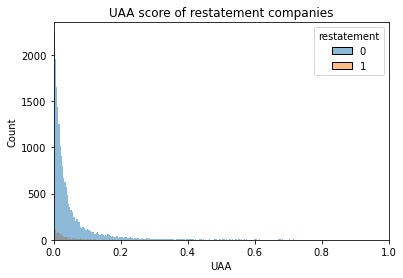

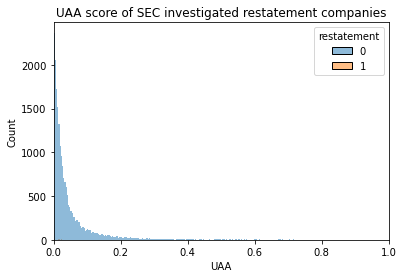

In [9]:
# Visualization
plot = sns.histplot(data=allRestatementDf, x='UAA', hue='restatement')
plot.set_xlim(0, 1)
plt.title('UAA score of restatement companies')
plt.show()

plot = sns.histplot(data=SECRestatementDf, x='UAA', hue='restatement')
plot.set_xlim(0, 1)
plt.title('UAA score of SEC investigated restatement companies')
plt.show()

Hypothesis test (Difference in mean) using all restatements.

In [9]:
resScores_all = allRestatementDf.loc[allRestatementDf['restatement'] == 1, ['UAA']]['UAA']
nonResScores_all = allRestatementDf.loc[allRestatementDf['restatement'] == 0, ['UAA']]['UAA']
numberOfRestatement_all = len(resScores_all)
print('There are ', numberOfRestatement_all, ' restatements among ', len(nonResScores_all) + numberOfRestatement_all, ' Observations')

# Tests if companies that restated have higher UAA scores (Lower earning quality)
t_stat, p_val = stats.ttest_ind(resScores_all, nonResScores_all, alternative='greater')
print("t-statistic:", t_stat)
print("p-value:", p_val)

There are  1710  restatements among  15687  Observations
t-statistic: 1.9648344047367838
p-value: 0.02472551542882908


A p value of 2.5% indicates strong evidence that the UAA scores of the restated companies tend to be higher.

Hypothesis test (Difference in mean) using SEC investigated restatements. The data is balanced before comparison to avoid bias.

In [10]:
resScores_SEC = SECRestatementDf.loc[SECRestatementDf['restatement'] == 1, ['UAA']]['UAA']
nonResScores_SEC = SECRestatementDf.loc[SECRestatementDf['restatement'] == 0, ['UAA']]['UAA']
numberOfRestatement_SEC = len(resScores_SEC)
print('There are ', numberOfRestatement_SEC, ' SEC restatements among ', len(nonResScores_SEC) + numberOfRestatement_SEC, ' Observations')

# Tests if companies that restated due to SEC investigation have higher UAA scores (Lower earning quality)
t_stat, p_val = stats.ttest_ind(resScores_SEC, nonResScores_SEC, alternative='greater')
print("t-statistic:", t_stat)
print("p-value:", p_val)

There are  108  SEC restatements among  15687  Observations
t-statistic: -0.6822749389731764
p-value: 0.752462404076568


We got a negative t stats as well as a P value of 0.75, which indicated that there is no evidence that those who restated their financial statements due to SEC investigations tend to have a higher UAA score (lower EQ). This inconsistency with the previous test where all restatements were used may be due to several reasons such as the extremely imbalanced dataset and a very small number for the SEQ investigated restatements

### Q2

It seems that firms that restated their financial statements do have a lower earnings quality. Because of this, it might be possible to use the UAA score as well as other financial metrics to predict if a company will restate its financial statements or not in the future. If the likelihood of restatement is high, there is a very likely that the current financial statement is of low quality and is subject to earnings management.

Let us build a predictive model to detect this. First of all, besides the UAA score (which indicates the abnormal accruals) that we have just tested, we should also include several other commonly used financial indices that might also help to detect earning management. All the indices will be initially included as predictors as we will try to include as many features as possible to minimize the risk of omitted variable bias and then performs feature reduction to remove the not important ones. All of these features have already been extracted during the ETL process.

Additional features to include:
1. Market indicators: Annual Percentage Stock Price Change and Earnings Yield
2. Liquidity indicator: Current Ratio
3. Solvency indicators: Debt To Equity
4. Profitability indicator: Return On Equity
5. Efficiency indicators: Asset Turnover

Model design:
We will be using the financial information (UAA scores, Annual stock price change, Earnings Yield, Current Ratio, Debt to equity, ROE and Asset Turnover) from year t-6 to year t to evaluate the financial statement quality of year t 

Let us assume that we are in year 2018 and the company just issued its financial statements. This model will be trying to predict if the newly released financial statement is subject to earnings management and will be restated in the future. We will be predicting this using the financial statement information from year 2012 to 2018.

We first need to make sec_2018 our target variable and change it to binary format with all restatement (0 for no restatement and 1 for filed restatement, regardless of SEC investigated or not)

In [11]:
dataset_train['binary_target_2018'] = dataset_train['sec_2018'].apply(binaryAllRestatement)
dataset_train.drop('sec_2018', axis='columns', inplace=True)
dataset_train

,sec_2012,sec_2013,sec_2014,sec_2015,sec_2016,sec_2017,UAA_mj_2012,UAA_mj_2013,UAA_mj_2014,UAA_mj_2015,...,roe_2017,roe_2018,at_2012,at_2013,at_2014,at_2015,at_2016,at_2017,at_2018,binary_target_2018
VRSN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.045735,0.044453,0.007894,0.065838,...,-0.362817,-0.420426,0.423565,0.362710,0.468762,0.449315,0.489240,0.396131,0.634613,0
NFG,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.011168,0.003441,0.016582,0.031151,...,0.166389,0.202093,0.274105,0.294218,0.313532,0.262739,0.257686,0.258856,0.263840,0
PRO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.014889,0.050311,0.058872,0.034513,...,1.658741,-1.170258,0.804149,0.805420,0.619172,0.637967,0.673285,0.584780,0.450890,0
LEAT,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.088420,0.028561,0.039435,0.053637,...,0.030385,0.132207,1.580424,1.589368,1.664584,1.664361,1.522581,1.582330,1.918505,0
ATHOF,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233332,0.038472,0.058690,0.118584,...,-0.137351,-0.589738,0.005507,0.025541,0.026678,0.024406,0.077381,0.324763,0.415795,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMED,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.002801,0.032320,0.051458,0.029428,...,-0.051133,-0.026694,0.788299,0.843256,1.004119,1.038688,1.107341,1.108055,1.207938,0
KSPN,0.0,0.0,0.0,0.0,0.0,-1.0,0.023112,0.033424,0.016891,0.024176,...,-0.268958,-1.528040,1.454587,1.260043,1.280280,1.232161,1.148338,1.786387,3.030077,0
DSGX,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.023334,0.018648,0.001929,0.002622,...,0.053886,0.058625,0.461544,0.439199,0.384646,0.408565,0.407118,0.379977,0.421180,0
BHE,-1.0,0.0,0.0,-1.0,-1.0,-1.0,0.033465,0.037193,0.004841,0.022329,...,-0.024055,0.020152,1.643815,1.512315,1.666019,1.341624,1.155977,1.176175,1.350925,0


Multivariate analysis - correlation matrix

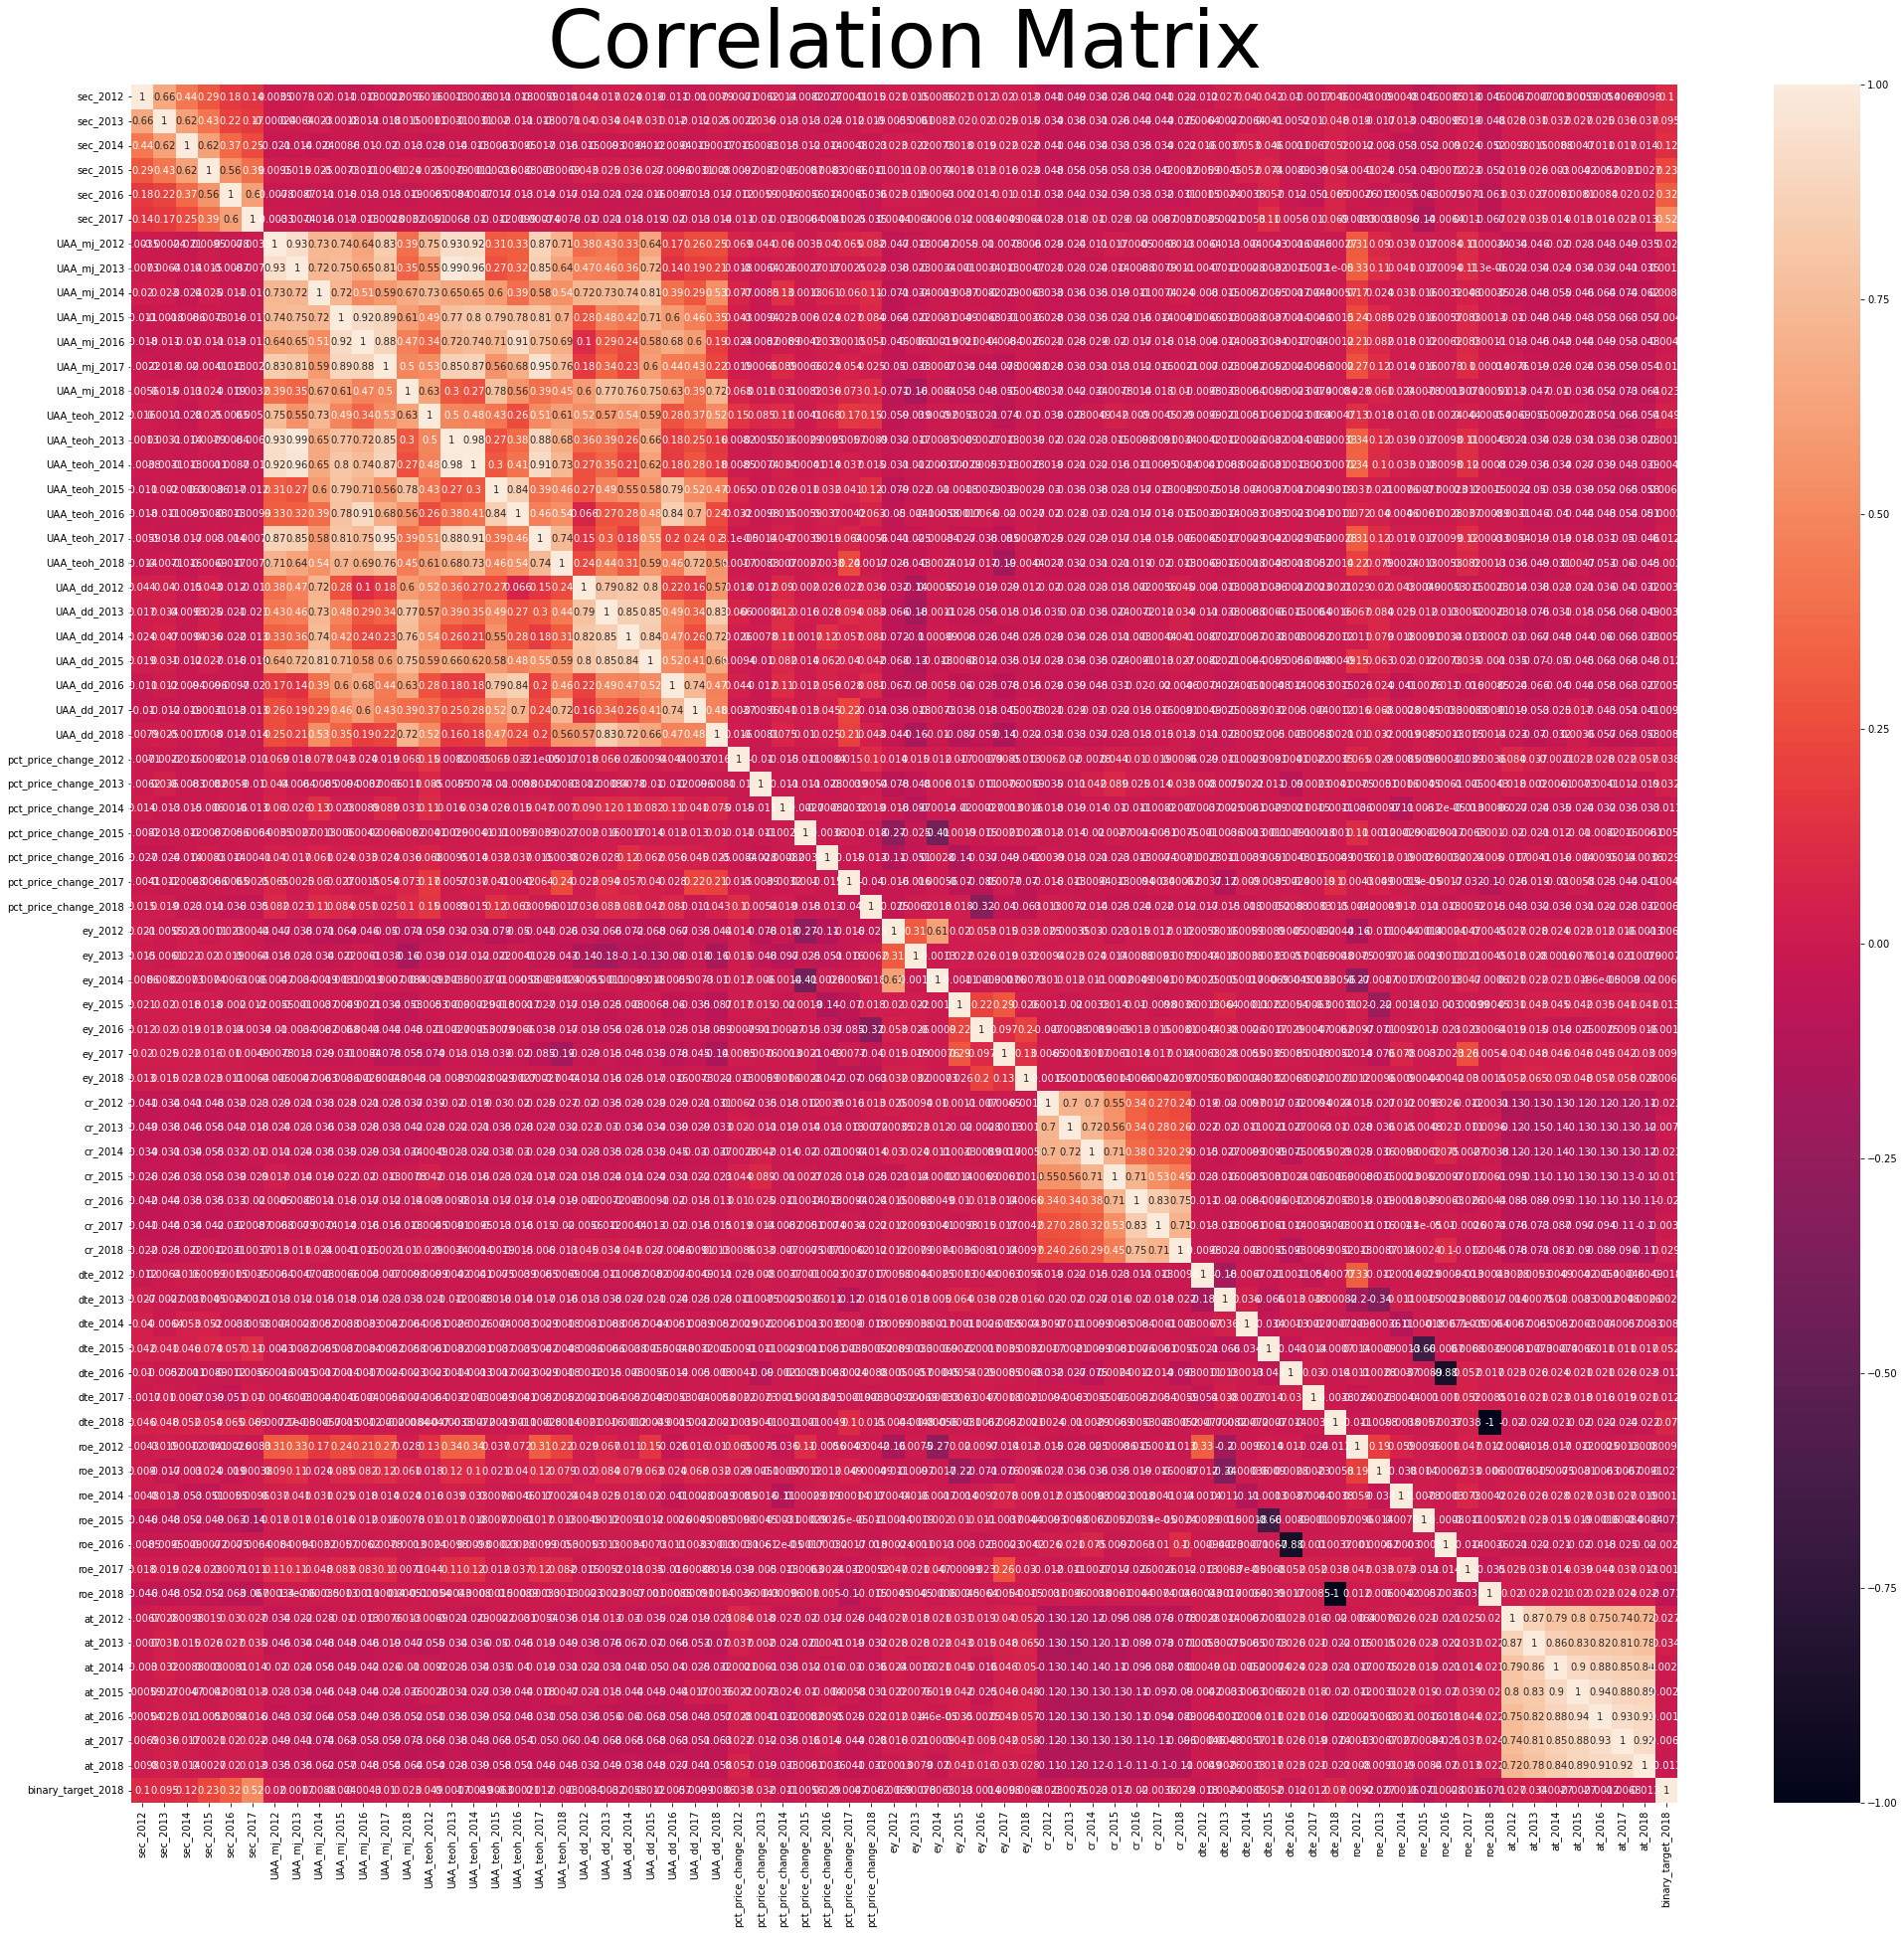

In [12]:
correlationMatrix = dataset_train.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(correlationMatrix, vmin=-1, vmax=1, annot=True)
plt.title('Correlation Matrix', fontsize=80)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.9)
plt.show()

Now let's try a few prediction models to see the performance

First prepare the training and validation data

In [13]:
X = dataset_train.drop('binary_target_2018', axis='columns')
y = dataset_train['binary_target_2018']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

------------------------------------------------------------------------------------------- Model Selection ------------------------------------------------------------------------------------------------

Lets first try a simple logistic regression model

In [14]:
logisticClassifier = LogisticRegression()
logisticClassifier.fit(X=X_train, y=y_train)
prediction_logi = logisticClassifier.predict(X_test)
accuracy_logi = accuracy_score(y_test, prediction_logi)
print('Logistic regression model prediction accuracy is: ', accuracy_logi)

Logistic regression model prediction accuracy is:  0.9042316258351893


Let's try KNN model

In [15]:
# Since KNN is a distance based algorithm, performing standardization of the dataset before training is important
scaler = preprocessing.MinMaxScaler()  # First create a scaler, this uses sklearn preprocessing library
X_train_scaled = scaler.fit_transform(X_train)  # We use fit_transform on the training data to fit the scaler
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test)  # We use the same training scaler to transform the test data
X_test_scaled = pd.DataFrame(X_test_scaled)
# Tune hyperparameter k neighbors with 5-fold cross validation
num_fold = 5
scoring = "accuracy"  # The closer to 0 the better
listOfScores = []  # This is basically a in-house grid search algorithm
k = 1
while k <= 200:
    knnClassifier = KNeighborsClassifier(n_neighbors=k, weights="distance")  # Weighted weighting
    cv_scores = cross_val_score(knnClassifier, X_train_scaled, y_train, cv=num_fold, scoring=scoring)  # Perform 5-fold cross validation
    cv_scores = np.mean(cv_scores)
    listOfScores.append([cv_scores, "k = " + str(k)])
    k = k + 1
print(max(listOfScores))  # Max evaluates the first number in each list in a list

# Best number of neighbor is 18. Use it to build our model
knnClassifier = KNeighborsClassifier(n_neighbors=18, weights="distance")
knnClassifier.fit(X_train_scaled, y_train)
prediction_knn = knnClassifier.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, prediction_knn)
print('KNN model prediction accuracy is: ', accuracy_knn)

[0.9308087331351832, 'k = 18']
KNN model prediction accuracy is:  0.9265033407572383


Let's try CART model

In [16]:
# Since there are several hyperparameters, we use gridsearch to fine tune the model
param_grid = {
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 50, 100, None],
    "min_samples_split": [2, 5, 10, 15, 20, 25, 30, 50, 100, None]
}
gridSearch_cart = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=param_grid, cv=5, n_jobs=-1)
gridSearch_cart.fit(X_train, y_train)
print('Best accuracy score is ', gridSearch_cart.best_score_)
print('Best hyperparameters are ', gridSearch_cart.best_params_)

# Let's use the best hyperparameters to build a CART model
cartModel = DecisionTreeClassifier(random_state=1, max_depth=1, min_samples_split=2)
cartModel.fit(X_train, y_train)
prediction_cart = cartModel.predict(X_test)
accuracy_cart = accuracy_score(y_test, prediction_cart)
print('CART prediction accuracy is: ', accuracy_cart)

Best accuracy score is  0.9341482392119638
Best hyperparameters are  {'max_depth': 1, 'min_samples_split': 2}
CART prediction accuracy is:  0.9220489977728286


Let's try to improve the decision tree's accuracy using random forest

In [17]:
# Use grid search to tune for the best hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],  # Minimum number of nodes required to perform a split
    'min_samples_leaf': [1, 2, 4, 10]  # Minimum number of nodes required for a leaf after splits
}
# Initialize the grid search
gridSearch_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=1), param_grid=param_grid, cv=5, n_jobs=-1)
# Fit the grid search to the training data
gridSearch_rf.fit(X_train, y_train)
print(gridSearch_rf.best_score_)
print(gridSearch_rf.best_params_)

# Let's use the best hyperparameters to build a random forest model
randomForestModel = RandomForestClassifier(random_state=1, max_depth=20, min_samples_leaf=2, min_samples_split=10,
                                           n_estimators=10)
randomForestModel.fit(X_train, y_train)
prediction_rf = randomForestModel.predict(X_test)
accuracy_rf = accuracy_score(y_test, prediction_rf)
print('Random forest prediction accuracy is: ', accuracy_rf)

0.9285787647251054
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
Random forest prediction accuracy is:  0.910913140311804


Let's try support vector machine (SVM)

In [18]:
# Since SVM is also a distance based algorithm, so using the standardized dataset is important
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}
svm = SVC(kernel='rbf', gamma='scale')
grid_search_svm = GridSearchCV(estimator=SVC(kernel='rbf', gamma='scale'), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_svm.fit(X_train_scaled, y_train)
print(grid_search_svm.best_score_)
print(grid_search_svm.best_params_)

# Build a SVM model using the best parameters
svmModel = SVC(kernel='rbf', C=10, gamma='scale')
svmModel.fit(X_train_scaled, y_train)
predictionSVM = svmModel.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, predictionSVM)
print('SVM prediction accuracy is: ', accuracy_svm)

0.9347068984298407
{'C': 10}
SVM prediction accuracy is:  0.9242761692650334


Now, we have the best hyperparameters of each classification models, time to see which one is the best

First let's define a function that uses cross validation to evaluate the model performance

In [19]:
def classificationModelPerformanceEvaluator(X, y, classifier, numOfRun, testSize, standardize=False, scaler=None):
    performanceList = []
    if standardize == False:
        n = 1
        while n <= numOfRun:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=None)
            classifier.fit(X_train, y_train)
            prediction = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, prediction)
            performanceList.append(accuracy)
            n = n + 1
        return performanceList
    else:
        n = 1
        while n <= numOfRun:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=None)
            X_train_scaled = scaler.fit_transform(X_train)  # We use fit_transform on the training data to fit the scaler
            X_train_scaled = pd.DataFrame(X_train_scaled)
            X_test_scaled = scaler.transform(X_test)  # We use the same training scaler to transform the test data
            X_test_scaled = pd.DataFrame(X_test_scaled)
            classifier.fit(X_train_scaled, y_train)
            prediction = classifier.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, prediction)
            performanceList.append(accuracy)
            n = n + 1
        return performanceList

Create our classifiers using the fine-tuned hyperparameters

In [20]:
bestLogiClassifier = LogisticRegression()
performanceListLogi = classificationModelPerformanceEvaluator(X=X, y=y, classifier=bestLogiClassifier, numOfRun=30, testSize=0.2)

bestKNNClassifier = KNeighborsClassifier(n_neighbors=18, weights="distance")
performanceListKNN = classificationModelPerformanceEvaluator(X=X, y=y, classifier=bestKNNClassifier, numOfRun=30, testSize=0.2,
                                                             standardize=True, scaler=preprocessing.MinMaxScaler())

bestCARTClassifier = DecisionTreeClassifier(max_depth=1, min_samples_split=2)
performanceListCART = classificationModelPerformanceEvaluator(X=X, y=y, classifier=bestCARTClassifier, numOfRun=30, testSize=0.2)

bestRandomForestClassifier = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=10)
performanceListRF = classificationModelPerformanceEvaluator(X=X, y=y, classifier=bestRandomForestClassifier, numOfRun=30, testSize=0.2)

bestSVMClassifier = SVC(kernel='rbf', C=10, gamma='scale')
performanceListSVM = classificationModelPerformanceEvaluator(X=X, y=y, classifier=bestSVMClassifier, numOfRun=30, testSize=0.2,
                                                             standardize=True, scaler=preprocessing.MinMaxScaler())

Evaluate model performance

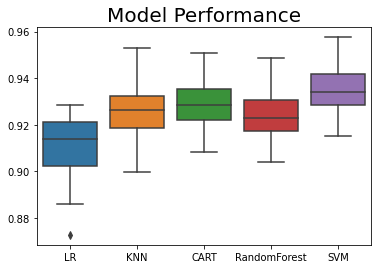

In [21]:
modelPerformance = pd.DataFrame({"LR": performanceListLogi,
                                 "KNN": performanceListKNN,
                                 "CART": performanceListCART,
                                 "RandomForest": performanceListRF,
                                 "SVM": performanceListSVM})
sns.boxplot(data=modelPerformance)
plt.title('Model Performance', fontsize=20)
plt.show()

As we can see from the graph, the SVM classifier clearly out performs the other classification models, using the Radial Basis Function kernel function, regularization parameter of 10 and a scale gamma.

Evaluation of feature importance

Since we cannot assume the linear relationships between our predictors and target variable, using lasso regression to perform feature reduction may be biased. Thus, we will use decision tree and entropy to evaluate what are the most important predictors.

In [21]:
decisionTreeModel = DecisionTreeClassifier(random_state=1)
decisionTreeModel.fit(X, y)

DecisionTreeClassifier(random_state=1)

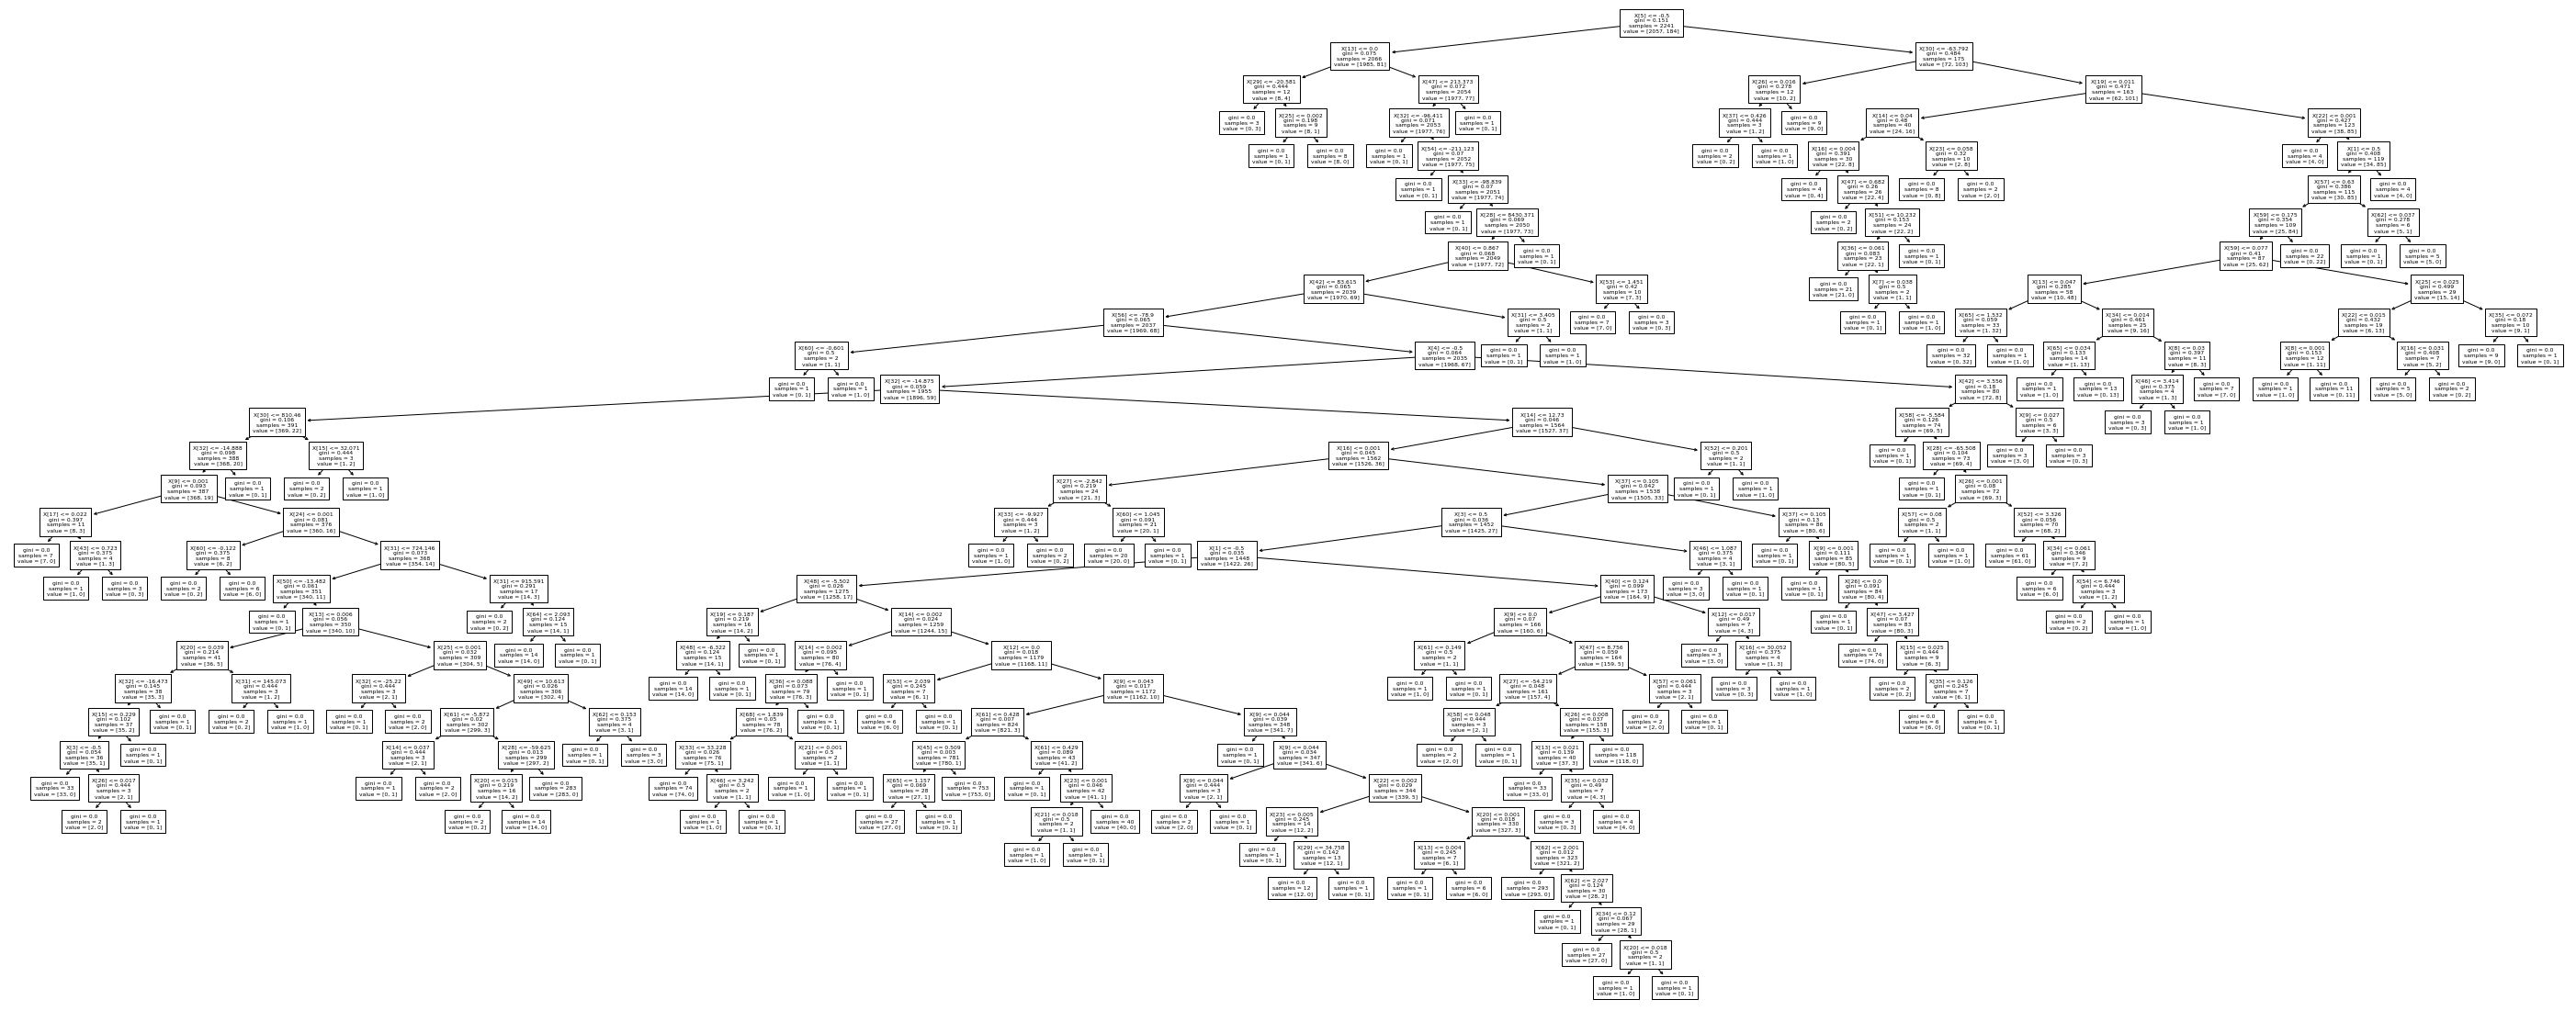

In [22]:
# Graph the tree
plt.figure(figsize=(50, 20))
tree.plot_tree(decisionTreeModel, fontsize=6)
plt.show()

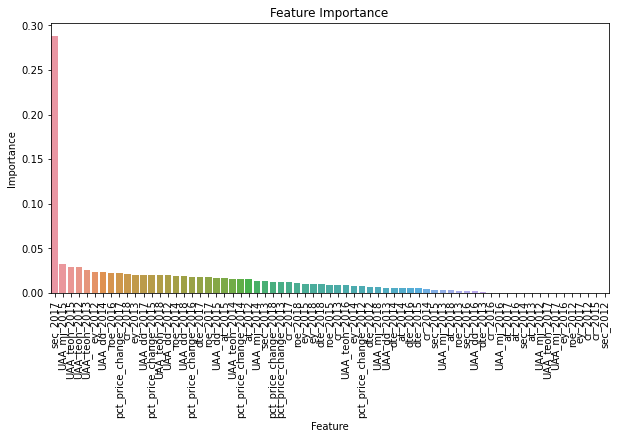

In [23]:
# When calculating feature importance, we do not want to prune the tree
model_importance = decisionTreeModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    rowAdded = pd.DataFrame([[X.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table.sort_values('Importance', inplace=True, ascending=False)
# Plot a bar chart to visualize feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=90)
plt.show()

As expected, the most important indicator of the current year's reporting quality is the restatement status of the previous year, since restatements usually happen in a consecutive years. However, this feature might not be as useful as it looks, because when we are evaluating the earnings quality of a particular year, the previous year's statement might not have been restated yet, even if it has potential problems.

Now the question is, should we exclude it?

Although, on one hand, it is true tht including this variable may lead to certain degree of information leakage, the benefit of keeping it outweigh the potential biases as many restatement were filed in the same financial year or in the next, so there is a very high likelihood that we will have the information on whether if the previous years financial statements were restated or not, when evaluating the current year's earnings quality, and if we do, our model should be able to capture that since it is a very strong indicator on the current year's restatement probability. The worst case scenario is that when evaluating the current year's financial statement quality, the previous years statements have not been restated yet, do they do have problems. In this case, the value that we will be using is 0 for previous years restatement status, and the model will continue to use other predictors to make predictions as usual, so there will be very minimal bias.

On the other hand, if we exclude this variable, and when we do have the information on the previous years restatement status when evaluating the current year's financial quality, our model will not be able to capture that information, and our model will have a major omitting variable bias.

The second important feature is the modified jones based UAA score of 2015, followed by 3 teoh based UAA scores.
Overall, most of these factors contribute to our predictive model, and should not be removed.

### Q3

Now let's evaluate our model using the reserved data from year 2019 to 2021

First we will re-import the full dataset

In [25]:
dataset = pd.read_csv('dataset.csv', index_col=0)

Since our training dataset is the financial data from year t0 to t-6, we also need to use 7 years of data to test

In [25]:
# Creating X_train and y_train using year 2018 as target
y_train = dataset['sec_2018'].apply(binaryAllRestatement)
X_train = dataset.drop(['sec_2018', 'sec_2019', 'sec_2020', 'sec_2021', 'UAA_mj_2019', 'UAA_mj_2020', 'UAA_mj_2021',
                        'UAA_teoh_2019', 'UAA_teoh_2020', 'UAA_teoh_2021', 'UAA_dd_2019', 'UAA_dd_2020', 'UAA_dd_2021',
                        'pct_price_change_2019', 'pct_price_change_2020', 'pct_price_change_2021',
                        'ey_2019', 'ey_2020', 'ey_2021', 'cr_2019', 'cr_2020', 'cr_2021', 'dte_2019', 'dte_2020', 'dte_2021',
                        'roe_2019', 'roe_2020', 'roe_2021', 'at_2019', 'at_2020', 'at_2021'], axis='columns')

In [26]:
# Creating y_test for year 2019, 2020 and 2021
y_test_2019 = dataset['sec_2019'].apply(binaryAllRestatement)
y_test_2020 = dataset['sec_2020'].apply(binaryAllRestatement)
y_test_2021 = dataset['sec_2021'].apply(binaryAllRestatement)

In [27]:
# Creating X_test for year 2019, 2020 and 2021
X_test_2019 = dataset.drop(['sec_2012', 'sec_2019', 'sec_2020', 'sec_2021', 'UAA_mj_2012', 'UAA_mj_2020', 'UAA_mj_2021',
                            'UAA_teoh_2012', 'UAA_teoh_2020', 'UAA_teoh_2021', 'UAA_dd_2012', 'UAA_dd_2020', 'UAA_dd_2021',
                              'pct_price_change_2012', 'pct_price_change_2020', 'pct_price_change_2021',
                              'ey_2012', 'ey_2020', 'ey_2021',
                              'cr_2012', 'cr_2020', 'cr_2021', 'dte_2012', 'dte_2020', 'dte_2021',
                              'roe_2012', 'roe_2020', 'roe_2021', 'at_2012', 'at_2020', 'at_2021'], axis='columns')

X_test_2020 = dataset.drop(['sec_2012', 'sec_2013', 'sec_2020', 'sec_2021', 'UAA_mj_2012', 'UAA_mj_2013', 'UAA_mj_2021',
                            'UAA_teoh_2012', 'UAA_teoh_2013', 'UAA_teoh_2021', 'UAA_dd_2012', 'UAA_dd_2013', 'UAA_dd_2021',
                              'pct_price_change_2012', 'pct_price_change_2013', 'pct_price_change_2021',
                              'ey_2012', 'ey_2013', 'ey_2021',
                              'cr_2012', 'cr_2013', 'cr_2021', 'dte_2012', 'dte_2013', 'dte_2021',
                              'roe_2012', 'roe_2013', 'roe_2021', 'at_2012', 'at_2013', 'at_2021'], axis='columns')

X_test_2021 = dataset.drop(['sec_2012', 'sec_2013', 'sec_2014', 'sec_2021', 'UAA_mj_2012', 'UAA_mj_2013', 'UAA_mj_2014',
                            'UAA_teoh_2012', 'UAA_teoh_2013', 'UAA_teoh_2014', 'UAA_dd_2012', 'UAA_dd_2013', 'UAA_dd_2014',
                              'pct_price_change_2012', 'pct_price_change_2013', 'pct_price_change_2014',
                              'ey_2012', 'ey_2013', 'ey_2014',
                              'cr_2012', 'cr_2013', 'cr_2014', 'dte_2012', 'dte_2013', 'dte_2014',
                              'roe_2012', 'roe_2013', 'roe_2014', 'at_2012', 'at_2013', 'at_2014'], axis='columns')

In [28]:
# Standardize our values
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # We use fit_transform on the training data to fit the scaler
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_2019_scaled = scaler.transform(X_test_2019)  # We use the same training scaler to transform the test data
# X_test_2019_scaled = pd.DataFrame(X_test_2019_scaled)
X_test_2020_scaled = scaler.transform(X_test_2020)  # We use the same training scaler to transform the test data
# X_test_2020_scaled = pd.DataFrame(X_test_2020_scaled)
X_test_2021_scaled = scaler.transform(X_test_2021)  # We use the same training scaler to transform the test data
# X_test_2021_scaled = pd.DataFrame(X_test_2021_scaled)

Train our SVM model

In [29]:
svmClassifier = SVC(probability=True, kernel='rbf', C=10, gamma='scale')
svmClassifier.fit(X_train_scaled, y_train)

SVC(C=10, probability=True)

In [30]:
# Predict 2019 probability using the model
prediction_prob_2019 = pd.DataFrame(svmClassifier.predict_proba(X_test_2019_scaled))
# Predict 2020 probability using the model
prediction_prob_2020 = pd.DataFrame(svmClassifier.predict_proba(X_test_2020_scaled))
# Predict 2021 probability using the model
prediction_prob_2021 = pd.DataFrame(svmClassifier.predict_proba(X_test_2021_scaled))

Let's find the top 100 company that most likely engaged in earning management in 2019, 2020 and 2021

In [31]:
shadyCompanyData = pd.DataFrame({'Company_Name': dataset.index, 'prediction_prob_2019': prediction_prob_2019[1],
                            'prediction_prob_2020': prediction_prob_2020[1],
                            'prediction_prob_2021': prediction_prob_2021[1]})

In [32]:
# Top 100 company in 2019
shadyCompany2019 = shadyCompanyData.sort_values('prediction_prob_2019', ascending=False)['Company_Name'][0:100].reset_index(drop=True)
shadyCompany2019

0      TRX
1      GVA
2      PPG
3      FLR
4      PBH
      ... 
95      LH
96     DLB
97    TEVA
98     TSN
99     HAE
Name: Company_Name, Length: 100, dtype: object

In [33]:
# Top 100 company in 2020
shadyCompany2020 = shadyCompanyData.sort_values('prediction_prob_2020', ascending=False)['Company_Name'][0:100].reset_index(drop=True)
shadyCompany2020

0     CHEF
1      TRX
2      GVA
3     XTNT
4      CRI
      ... 
95     AON
96    RMBS
97    DALN
98     CPS
99    PENN
Name: Company_Name, Length: 100, dtype: object

In [34]:
# Top 100 company in 2021
shadyCompany2021 = shadyCompanyData.sort_values('prediction_prob_2021', ascending=False)['Company_Name'][0:100].reset_index(drop=True)
shadyCompany2021

0     CHEF
1      TRX
2      AIM
3     FALC
4     GIFI
      ... 
95    LSAK
96    SHEN
97     NGG
98     WPP
99     FLS
Name: Company_Name, Length: 100, dtype: object

Evaluate prediction accuracy

In [35]:
# Predict 2019 value using the model
prediction_2019 = pd.DataFrame(svmClassifier.predict(X_test_2019_scaled))
accuracy_2019 = accuracy_score(y_test_2019, prediction_2019)
print('2019 prediction accuracy is: ', accuracy_2019)

# Predict 2020 value using the model
prediction_2020 = pd.DataFrame(svmClassifier.predict(X_test_2020_scaled))
accuracy_2020 = accuracy_score(y_test_2020, prediction_2020)
print('2020 prediction accuracy is: ', accuracy_2020)

# Predict 2021 value using the model
prediction_2021 = pd.DataFrame(svmClassifier.predict(X_test_2021_scaled))
accuracy_2021 = accuracy_score(y_test_2021, prediction_2021)
print('2021 prediction accuracy is: ', accuracy_2021)

2019 prediction accuracy is:  0.9236947791164659
2020 prediction accuracy is:  0.9361892012494422
2021 prediction accuracy is:  0.9540383757251227


The model accuracy is pretty high, how about its precision? After all, we want to know if a company is flagged as a potential earning manager, how confident can we be? Let's evaluate this using the most suspected companies detected in the previous step 

In [36]:
top100FirmList_2021 = []
for firm in dataset.index:
    top100FirmList_2021.append(firm in shadyCompany2021.values)
prediction_precision_2021 = dataset.loc[top100FirmList_2021, 'sec_2021'].apply(binaryAllRestatement).sum()

top100FirmList_2020 = []
for firm in dataset.index:
    top100FirmList_2020.append(firm in shadyCompany2020.values)
prediction_precision_2020 = dataset.loc[top100FirmList_2020, 'sec_2020'].apply(binaryAllRestatement).sum()

top100FirmList_2019 = []
for firm in dataset.index:
    top100FirmList_2019.append(firm in shadyCompany2019.values)
prediction_precision_2019 = dataset.loc[top100FirmList_2019, 'sec_2019'].apply(binaryAllRestatement).sum()

print('In 2019, if a firm is predicted to be of low earning quality, it has ', prediction_precision_2019, '% probability that it will restate its statement in the future')
print('In 2020, if a firm is predicted to be of low earning quality, it has ', prediction_precision_2020, '% probability that it will restate its statement in the future')
print('In 2021, if a firm is predicted to be of low earning quality, it has ', prediction_precision_2021, '% probability that it will restate its statement in the future')

In 2019, if a firm is predicted to be of low earning quality, it has  43 % probability that it will restate its statement in the future
In 2020, if a firm is predicted to be of low earning quality, it has  41 % probability that it will restate its statement in the future
In 2021, if a firm is predicted to be of low earning quality, it has  33 % probability that it will restate its statement in the future


As we can see, although the precision is not as good as the total model accuracy, considering the huge imbalance in our dataset,  the prediction result is still quite informative, and can be very useful if used as an additional indicator for the analyst when evaluating a certain company's financial statement quality. Also, a very likely reason for the precision score to deteriorate from 2019 to 2020 to 2021 might because our model is trained on year 2018, and the further away from our training year, the less accurate our model will be. When using the model in real time, we will have access to all the financial data up to the evaluating year so the model will always be trained using the latest data.

## Q4

Let's see if we can make a better prediction using EQ scores and decile segmentation on top of our ML prediction models. We will be testing it using the 2021 data and compare it with the result we got from the pure SVM model.

First, let's separate out the 2021 data UAA scores

In [26]:
UAAData2021 = dataset[['UAA_mj_2021', 'UAA_teoh_2021', 'UAA_dd_2021', 'sec_2021']]

Assign decile index to each company based on the 3 UAA scores

Let's first define some functions to facilitate the process

In [27]:
def percentileList(array, splitType='deciles'):
    if splitType == 'deciles':
        decilesList = []
        n = 10
        while n <= 90:
            decilesList.append(np.percentile(array, n))
            n = n + 10
        return decilesList
    if splitType == 'quintiles':
        quintilesList = []
        n = 20
        while n <= 80:
            quintilesList.append(np.percentile(array, n))
            n = n + 20
        return quintilesList
    if splitType == 'quartiles':
        quartilesList = []
        n = 25
        while n <= 75:
            quartilesList.append(np.percentile(array, n))
            n = n + 25
        return quartilesList


def assignDecile(value, decileList):
    n = 0
    while n < 9:
        if value < decileList[n]:
            return n + 1
        if value >= decileList[8]:
            return 10
        n = n + 1

Calculate decile using each of the 3 UAA models, and combined them to calculate an EQ index

In [28]:
# Calculate the decile index using modified jones UAA scores
deciles_mj_2021 = percentileList(UAAData2021['UAA_mj_2021'], splitType='deciles')
UAAData2021['mj_deciles'] = UAAData2021['UAA_mj_2021'].apply(lambda x: assignDecile(x, deciles_mj_2021))

# Calculate the decile index using teoh UAA scores
deciles_teoh_2021 = percentileList(UAAData2021['UAA_teoh_2021'], splitType='deciles')
UAAData2021['teoh_deciles'] = UAAData2021['UAA_teoh_2021'].apply(lambda x: assignDecile(x, deciles_teoh_2021))

# Calculate the decile index using dd UAA scores
deciles_dd_2021 = percentileList(UAAData2021['UAA_dd_2021'], splitType='deciles')
UAAData2021['dd_deciles'] = UAAData2021['UAA_dd_2021'].apply(lambda x: assignDecile(x, deciles_dd_2021))

# Calculate a combined EQ index (The lower the better)
UAAData2021['EQ_index'] = UAAData2021['mj_deciles'] + UAAData2021['teoh_deciles'] + UAAData2021['dd_deciles']
UAAData2021

,UAA_mj_2021,UAA_teoh_2021,UAA_dd_2021,sec_2021,mj_deciles,teoh_deciles,dd_deciles,EQ_index
VRSN,0.031082,0.027785,0.014959,-1.0,6,6,5,17
NFG,0.025583,0.032536,0.018344,-1.0,6,6,6,18
PRO,0.014732,0.047248,0.012880,-1.0,4,7,5,16
LEAT,0.026628,0.059008,0.010896,-1.0,6,8,4,18
ATHOF,0.046580,0.094695,0.016054,-1.0,8,9,5,22
...,...,...,...,...,...,...,...,...
SMED,0.005234,0.009171,0.007558,0.0,2,3,3,8
KSPN,0.007405,0.031343,0.002942,-1.0,3,6,2,11
DSGX,0.014617,0.000867,0.004829,-1.0,4,1,2,7
BHE,0.026173,0.061632,0.052917,-1.0,6,8,9,23


Now let's redo the hypothesis test, but this time with the newly created EQ_index

In [29]:
# Create an all restatement dataframe
allRestatementDf = UAAData2021[['sec_2021', 'EQ_index']]
allRestatementDf['restatement'] = allRestatementDf['sec_2021'].apply(binaryAllRestatement)

# Create an SEC investigated only restatement dataframe
SECRestatementDf = UAAData2021[['sec_2021', 'EQ_index']]
SECRestatementDf['restatement'] = SECRestatementDf['sec_2021'].apply(binarySECRestatement)

# Hypothesis test using restatement
resScores_all = allRestatementDf.loc[allRestatementDf['restatement'] == 1, ['EQ_index']]['EQ_index']
nonResScores_all = allRestatementDf.loc[allRestatementDf['restatement'] == 0, ['EQ_index']]['EQ_index']
numberOfRestatement_all = len(resScores_all)
print('There are ', numberOfRestatement_all, ' restatements among ', len(nonResScores_all) + numberOfRestatement_all, ' Observations')

# Test difference in means
t_stat, p_val = stats.ttest_ind(resScores_all, nonResScores_all, alternative='greater')
print("t-statistic:", t_stat)
print("p-value:", p_val)

There are  63  restatements among  2241  Observations
t-statistic: 3.3753932122763226
p-value: 0.0003748399335032735


We saw a big improvement in the test's P value which decreased from the previous 2.5% to 0.04%. This shows that the EQ index is a much stronger indicator than the single UAA score for whether if the company's statement will be restated or not.

In [30]:
# Hypothesis test using sec investigated restatement
resScores_SEC = SECRestatementDf.loc[SECRestatementDf['restatement'] == 1, ['EQ_index']]['EQ_index']
nonResScores_SEC = SECRestatementDf.loc[SECRestatementDf['restatement'] == 0, ['EQ_index']]['EQ_index']
numberOfRestatement_SEC = len(resScores_SEC)
print('There are ', numberOfRestatement_SEC, ' SEC restatements among ', len(nonResScores_SEC) + numberOfRestatement_SEC, ' Observations')

# Test difference in means
t_stat, p_val = stats.ttest_ind(resScores_SEC, nonResScores_SEC, alternative='greater')
print("t-statistic:", t_stat)
print("p-value:", p_val)

There are  2  SEC restatements among  2241  Observations
t-statistic: 1.6762619681446373
p-value: 0.04691324970388801


The p value was improved from the previous inconclusive 0.75 to 0.05, which again, proves that the EQ index is indeed a better indicator than one single UAA score. This also allows us to reject the null hypotheses with a confidence level of nearly 95% and proves that companies that restated due to SEC investigations do have, on average, a worse earning quality.

Let us include this new index into our prediction model and see if we can improve our prediction results

First, we need to calculate the index value for each year, let's define a function to facilitate the process

In [31]:
def calculateEQIndex(year):
    UAAData = dataset[[f'UAA_mj_{year}', f'UAA_teoh_{year}', f'UAA_dd_{year}', f'sec_{year}']]
    # Calculate the decile index using modified jones UAA scores
    deciles_mj = percentileList(UAAData[f'UAA_mj_{year}'], splitType='deciles')
    UAAData['mj_deciles'] = UAAData[f'UAA_mj_{year}'].apply(lambda x: assignDecile(x, deciles_mj))
    # Calculate the decile index using teoh UAA scores
    deciles_teoh = percentileList(UAAData[f'UAA_teoh_{year}'], splitType='deciles')
    UAAData['teoh_deciles'] = UAAData[f'UAA_teoh_{year}'].apply(lambda x: assignDecile(x, deciles_teoh))
    # Calculate the decile index using dd UAA scores
    deciles_dd = percentileList(UAAData[f'UAA_dd_{year}'], splitType='deciles')
    UAAData['dd_deciles'] = UAAData[f'UAA_dd_{year}'].apply(lambda x: assignDecile(x, deciles_dd))
    # Calculate a combined EQ index (The lower the better)
    UAAData['EQ_index'] = UAAData['mj_deciles'] + UAAData['teoh_deciles'] + UAAData['dd_deciles']
    return UAAData['EQ_index']

Calculate EQ indices

In [32]:
dataset['EQ_index_2012'] = calculateEQIndex(2012)
dataset['EQ_index_2013'] = calculateEQIndex(2013)
dataset['EQ_index_2014'] = calculateEQIndex(2014)
dataset['EQ_index_2015'] = calculateEQIndex(2015)
dataset['EQ_index_2016'] = calculateEQIndex(2016)
dataset['EQ_index_2017'] = calculateEQIndex(2017)
dataset['EQ_index_2018'] = calculateEQIndex(2018)
dataset['EQ_index_2019'] = calculateEQIndex(2019)
dataset['EQ_index_2020'] = calculateEQIndex(2020)
dataset['EQ_index_2021'] = calculateEQIndex(2021)
dataset

,sec_2012,sec_2013,sec_2014,sec_2015,sec_2016,sec_2017,sec_2018,sec_2019,sec_2020,sec_2021,...,EQ_index_2012,EQ_index_2013,EQ_index_2014,EQ_index_2015,EQ_index_2016,EQ_index_2017,EQ_index_2018,EQ_index_2019,EQ_index_2020,EQ_index_2021
VRSN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,16,17,6,20,10,15,19,24,26,17
NFG,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,11,8,19,19,12,12,24,7,16,18
PRO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,10,25,17,25,6,24,23,14,24,16
LEAT,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,24,15,21,18,19,19,11,16,20,18
ATHOF,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,29,25,24,20,24,21,24,26,24,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMED,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,12,22,25,16,11,10,16,18,21,8
KSPN,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,21,17,19,16,21,19,23,27,23,11
DSGX,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,16,15,6,4,16,5,15,9,9,7
BHE,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,23,20,7,13,21,14,16,7,15,23


Let us re-train our svm model. This time, we will be training our model using data from 2012 to 2020.

Since our model's input is 7 years rolling window, we first need to prepare our training dataset by stacking 7 years of rolling window data on top of each other, so our columns become t-6, t-5, t-4, t-3, t-2, t-1 and t, instead of specific years. We will be using year 2012 to 2018 as the first rolling window, 13 to 19 as the second rolling window and 14 to 20 as the third rolling window. 

In [33]:
# Creating X_train and y_train using year 2018 as target
y_train_2018 = dataset['sec_2018'].apply(binaryAllRestatement)
X_train_2018 = dataset.drop(['sec_2018', 'sec_2019', 'sec_2020', 'sec_2021', 'UAA_mj_2019', 'UAA_mj_2020', 'UAA_mj_2021',
                        'UAA_teoh_2019', 'UAA_teoh_2020', 'UAA_teoh_2021', 'UAA_dd_2019', 'UAA_dd_2020', 'UAA_dd_2021',
                        'pct_price_change_2019', 'pct_price_change_2020', 'pct_price_change_2021',
                        'ey_2019', 'ey_2020', 'ey_2021', 'cr_2019', 'cr_2020', 'cr_2021', 'dte_2019', 'dte_2020', 'dte_2021',
                        'roe_2019', 'roe_2020', 'roe_2021', 'at_2019', 'at_2020', 'at_2021',
                             'EQ_index_2019', 'EQ_index_2020', 'EQ_index_2021'], axis='columns')
# Creating X_train and y_train using year 2019 as target
y_train_2019 = dataset['sec_2019'].apply(binaryAllRestatement)
X_train_2019 = dataset.drop(['sec_2012', 'sec_2019', 'sec_2020', 'sec_2021', 'UAA_mj_2012', 'UAA_mj_2020', 'UAA_mj_2021',
                            'UAA_teoh_2012', 'UAA_teoh_2020', 'UAA_teoh_2021', 'UAA_dd_2012', 'UAA_dd_2020', 'UAA_dd_2021',
                              'pct_price_change_2012', 'pct_price_change_2020', 'pct_price_change_2021',
                              'ey_2012', 'ey_2020', 'ey_2021',
                              'cr_2012', 'cr_2020', 'cr_2021', 'dte_2012', 'dte_2020', 'dte_2021',
                              'roe_2012', 'roe_2020', 'roe_2021', 'at_2012', 'at_2020', 'at_2021',
                             'EQ_index_2012', 'EQ_index_2020', 'EQ_index_2021'], axis='columns')
# Creating X_train and y_train using year 2020 as target
y_train_2020 = dataset['sec_2020'].apply(binaryAllRestatement)
X_train_2020 = dataset.drop(['sec_2012', 'sec_2013', 'sec_2020', 'sec_2021', 'UAA_mj_2012', 'UAA_mj_2013', 'UAA_mj_2021',
                            'UAA_teoh_2012', 'UAA_teoh_2013', 'UAA_teoh_2021', 'UAA_dd_2012', 'UAA_dd_2013', 'UAA_dd_2021',
                              'pct_price_change_2012', 'pct_price_change_2013', 'pct_price_change_2021',
                              'ey_2012', 'ey_2013', 'ey_2021',
                              'cr_2012', 'cr_2013', 'cr_2021', 'dte_2012', 'dte_2013', 'dte_2021',
                              'roe_2012', 'roe_2013', 'roe_2021', 'at_2012', 'at_2013', 'at_2021',
                             'EQ_index_2012', 'EQ_index_2013', 'EQ_index_2021'], axis='columns')

# Rename the columns
columnNames =['sec_t-6', 'sec_t-5', 'sec_t-4', 'sec_t-3', 'sec_t-2', 'sec_t-1',
            'UAA_mj_t-6', 'UAA_mj_t-5', 'UAA_mj_t-4', 'UAA_mj_t-3', 'UAA_mj_t-2', 'UAA_mj_t-1', 'UAA_mj_t',
            'UAA_teoh_t-6', 'UAA_teoh_t-5', 'UAA_teoh_t-4', 'UAA_teoh_t-3', 'UAA_teoh_t-2', 'UAA_teoh_t-1', 'UAA_teoh_t',
            'UAA_dd_t-6', 'UAA_dd_t-5', 'UAA_dd_t-4', 'UAA_dd_t-3', 'UAA_dd_t-2', 'UAA_dd_t-1', 'UAA_dd_t',
            'pct_price_change_t-6', 'pct_price_change_t-5', 'pct_price_change_t-4', 'pct_price_change_t-3', 'pct_price_change_t-2', 'pct_price_change_t-1', 'pct_price_change_t',
            'ey_t-6', 'ey_t-5', 'ey_t-4', 'ey_t-3', 'ey_t-2', 'ey_t-1', 'ey_t',
            'cr_t-6', 'cr_t-5', 'cr_t-4', 'cr_t-3', 'cr_t-2', 'cr_t-1', 'cr_t',
            'dte_t-6', 'dte_t-5', 'dte_t-4', 'dte_t-3', 'dte_t-2', 'dte_t-1', 'dte_t',
            'roe_t-6', 'roe_t-5', 'roe_t-4', 'roe_t-3', 'roe_t-2', 'roe_t-1', 'roe_t',
            'at_t-6', 'at_t-5', 'at_t-4', 'at_t-3', 'at_t-2', 'at_t-1', 'at_t',
            'EQ_index_t-6', 'EQ_index_t-5', 'EQ_index_t-4', 'EQ_index_t-3', 'EQ_index_t-2', 'EQ_index_t-1', 'EQ_index_t']

X_train_2018.columns = columnNames
X_train_2019.columns = columnNames
X_train_2020.columns = columnNames

# Stack 3 years' training data together
X_train = pd.concat([X_train_2018, X_train_2019, X_train_2020], axis='index')
y_train = pd.concat([y_train_2018, y_train_2019, y_train_2020])
X_train

,sec_t-6,sec_t-5,sec_t-4,sec_t-3,sec_t-2,sec_t-1,UAA_mj_t-6,UAA_mj_t-5,UAA_mj_t-4,UAA_mj_t-3,...,at_t-2,at_t-1,at_t,EQ_index_t-6,EQ_index_t-5,EQ_index_t-4,EQ_index_t-3,EQ_index_t-2,EQ_index_t-1,EQ_index_t
VRSN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.045735,0.044453,0.007894,0.065838,...,0.489240,0.396131,0.634613,16,17,6,20,10,15,19
NFG,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.011168,0.003441,0.016582,0.031151,...,0.257686,0.258856,0.263840,11,8,19,19,12,12,24
PRO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.014889,0.050311,0.058872,0.034513,...,0.673285,0.584780,0.450890,10,25,17,25,6,24,23
LEAT,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.088420,0.028561,0.039435,0.053637,...,1.522581,1.582330,1.918505,24,15,21,18,19,19,11
ATHOF,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233332,0.038472,0.058690,0.118584,...,0.077381,0.324763,0.415795,29,25,24,20,24,21,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMED,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.051458,0.029428,0.004967,0.007802,...,1.207938,1.229523,0.944769,25,16,11,10,16,18,21
KSPN,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.016891,0.024176,0.018384,0.137519,...,3.030077,3.332464,3.496092,19,16,21,19,23,27,23
DSGX,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.001929,0.002622,0.022466,0.004418,...,0.421180,0.345635,0.327922,6,4,16,5,15,9,9
BHE,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.004841,0.022329,0.035440,0.020587,...,1.350925,1.288783,1.177095,7,13,21,14,16,7,15


Create our test data using 2021's data

In [34]:
# Test data
X_test_2021 = dataset.drop(['sec_2012', 'sec_2013', 'sec_2014', 'sec_2021', 'UAA_mj_2012', 'UAA_mj_2013', 'UAA_mj_2014',
                            'UAA_teoh_2012', 'UAA_teoh_2013', 'UAA_teoh_2014', 'UAA_dd_2012', 'UAA_dd_2013', 'UAA_dd_2014',
                              'pct_price_change_2012', 'pct_price_change_2013', 'pct_price_change_2014',
                              'ey_2012', 'ey_2013', 'ey_2014',
                              'cr_2012', 'cr_2013', 'cr_2014', 'dte_2012', 'dte_2013', 'dte_2014',
                              'roe_2012', 'roe_2013', 'roe_2014', 'at_2012', 'at_2013', 'at_2014',
                            'EQ_index_2012', 'EQ_index_2013', 'EQ_index_2014'], axis='columns')
y_test_2021 = dataset['sec_2021'].apply(binaryAllRestatement)
X_test_2021

,sec_2015,sec_2016,sec_2017,sec_2018,sec_2019,sec_2020,UAA_mj_2015,UAA_mj_2016,UAA_mj_2017,UAA_mj_2018,...,at_2019,at_2020,at_2021,EQ_index_2015,EQ_index_2016,EQ_index_2017,EQ_index_2018,EQ_index_2019,EQ_index_2020,EQ_index_2021
VRSN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.065838,0.002397,0.039977,0.051397,...,0.664323,0.715969,0.669221,20,10,15,19,24,26,17
NFG,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.031151,0.020004,0.024271,0.049366,...,0.262038,0.222011,0.233449,19,12,12,24,7,16,18
PRO,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.034513,0.009330,0.053921,0.036855,...,0.487689,0.467477,0.508456,25,6,24,23,14,24,16
LEAT,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.053637,0.028401,0.061802,0.014584,...,1.559490,1.474749,1.477800,18,19,19,11,16,20,18
ATHOF,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.118584,0.035915,0.055675,0.137973,...,0.369881,0.351362,0.478055,20,24,21,24,26,24,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMED,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.029428,0.004967,0.007802,0.010072,...,1.229523,0.944769,1.013164,16,11,10,16,18,21,8
KSPN,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.024176,0.018384,0.137519,0.058771,...,3.332464,3.496092,3.078553,16,21,19,23,27,23,11
DSGX,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.002622,0.022466,0.004418,0.017697,...,0.345635,0.327922,0.358258,4,16,5,15,9,9,7
BHE,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.022329,0.035440,0.020587,0.046481,...,1.288783,1.177095,1.184591,13,21,14,16,7,15,23


Retrain our SVM model

In [35]:
# Standardize our values
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # We use fit_transform on the training data to fit the scaler
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_2021_scaled = scaler.transform(X_test_2021)  # We use the same training scaler to transform the test data
X_test_2021_scaled = pd.DataFrame(X_test_2021_scaled)

# Train our SVM model
svmClassifier = SVC(probability=True, kernel='rbf', C=10, gamma='scale')
svmClassifier.fit(X_train_scaled, y_train)

# Predict 2021 value using the model
prediction_2021 = pd.DataFrame(svmClassifier.predict(X_test_2021_scaled))
accuracy_2021 = accuracy_score(y_test_2021, prediction_2021)
print('2021 prediction accuracy is: ', accuracy_2021)

2021 prediction accuracy is:  0.9705488621151271


We have successfully improved our prediction accuracy from 95% to 97%

Let us wrap up our model and research by producing a list of 10 companies of which the financial statements are most likely to be restated due to potential earnings management, in the year of 2021

In [38]:
# Predict 2021 probability using the new model
prediction_prob_2021 = pd.DataFrame(svmClassifier.predict_proba(X_test_2021_scaled))

# Let's find the top 10 company that most likely engaged in earning management in 2021
shadyCompanyData = pd.DataFrame({'Company_Name': dataset.index, 'prediction_prob_2021': prediction_prob_2021[1],
                                 'actual_result_2021': list(y_test_2021)})

# Top 10 company in 2021
top10ShadyCompany2021 = pd.DataFrame(shadyCompanyData.sort_values('prediction_prob_2021', ascending=False)[0:10].reset_index(drop=True)[['Company_Name', 'prediction_prob_2021']])
top10ShadyCompany2021

,Company_Name,prediction_prob_2021
0,AZZ,0.729300
1,CHEF,0.708754
2,ESE,0.688591
3,BKH,0.660800
4,FAST,0.656444
5,WWE,0.643577
6,CMP,0.628999
7,LEE,0.588587
8,WTW,0.567664
9,MMC,0.562175


Manually select 5 among them by inspecting their financials

In [23]:
dataset['companyName'] = dataset.index
top10ShadyCompany2021 = top10ShadyCompany2021.join(dataset.set_index('companyName'), on='Company_Name', how='left')
top10ShadyCompany2021

,Company_Name,sec_2012,sec_2013,sec_2014,sec_2015,sec_2016,sec_2017,sec_2018,sec_2019,sec_2020,...,EQ_index_2012,EQ_index_2013,EQ_index_2014,EQ_index_2015,EQ_index_2016,EQ_index_2017,EQ_index_2018,EQ_index_2019,EQ_index_2020,EQ_index_2021
0,AZZ,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,7,8,7,10,4,9,7,13,16,21
1,CHEF,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,...,10,10,16,23,15,15,11,14,13,14
2,ESE,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,...,19,10,16,6,6,5,3,6,17,17
3,BKH,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,...,17,5,9,12,9,11,7,10,4,19
4,FAST,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,8,10,8,10,3,3,17,10,21,22
5,WWE,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,16,19,26,24,23,5,17,6,26,27
6,CMP,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,12,19,17,17,16,10,14,14,10,26
7,LEE,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,...,9,23,11,12,16,12,18,13,19,21
8,WTW,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,22,7,12,19,6,8,11,8,16,22
9,MMC,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,6,14,16,3,7,4,12,3,10,15


One of the strongest incentives for the management to engage in earning management is to avoid the reporting of a negative ROE in the current reporting year. A strong evidence of this is that the distribution curve of ROE scores usually dive just before the 0 benchmark point and spike back up immediately once over 0 as companies with close to 0 but negative ROE tries to manage their earnings up a little to make it positive. Thus, companies with just over 0 but positive ROEs are very likely to have engaged in earnings management.

The second qualitative factor we want to focus on is Auditor's Opinion. Auditor are trained to identify material misstatements, whether due to fraud or error, in the financial statements. A company with a history of clean audit opinions is generally considered to have a lower risk of earnings management than a company with a history of qualified, adverse, or disclaimed opinions.

The third qualitative factor we want to look at is market cap. Comparing to large-cap, mid-cap or even small-cap companies, micro-cap companies are more likely to engage in earning managements for several reasons.
1. Pressure to meet expectations: Micro-cap companies are usually at an earlier stage of development and may face greater pressure to show profitability and growth to attract investors. This can lead to aggressive accounting practices, including manipulating earnings figures, to meet or exceed market expectations.
2. Limited resources and expertise: Smaller companies may not have the same level of resources or access to expertise as larger firms. This can result in less robust internal controls, making it easier for management to manipulate financial reports.
3. Less scrutiny from regulators and auditors: Micro-cap companies typically receive less attention from regulatory agencies, financial analysts, and auditors due to their smaller size and lower market capitalization. This decreased scrutiny may provide more opportunities for earnings management to go unnoticed.
4. Lower liquidity and trading volume: Micro-cap stocks often have lower trading volumes and less liquidity, which can lead to greater price volatility. Some managers might manipulate earnings to create a more favorable impression of the company and boost the stock price, taking advantage of the low liquidity.
5. Incentive structures: Managers of micro-cap companies might be more likely to engage in earnings management if their compensation packages are tied to short-term performance metrics, such as earnings per share or stock price. These incentives could encourage managers to manipulate financial statements to achieve personal financial gains.

After evaluating the ROE, auditor's opinion and market cap of all 10 companies, the following 5 companies were selected:

MMC
WTW
CMP
WWE
ESE

All 5 companies have restated their 2021 financial statements later